# Baseline Results for Multi-modal Approaches

Evaluation metrics used:

- ROC/AUC
- Accuracy 
- Precision
- Recall
- F1-score

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow_addons as tfa

from pathlib import Path
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Layer, Input, LSTM, Dense, Flatten, TimeDistributed, Conv1D,  MaxPooling1D, ConvLSTM1D, BatchNormalization, Bidirectional, PReLU, Concatenate
from tensorflow.keras import models, Model
from tensorflow.keras.initializers import Constant

## Methods for loading datasets and creating model architectures

In [2]:
def load_file(file):
    df = pd.read_csv(file, header=0)
    labels = df['pain']
    df = df.drop(columns=['pain'])
    df.drop(df.columns[-1], axis=1, inplace=True)
    return df, labels

def load_dataset(input_filepath, modality):
    feature_names = []
    classes = []
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    train_filepath = data_dir / input_filepath / 'train' / modality
    test_filepath = data_dir / input_filepath / 'test' / modality
    # 1. Load train data
    X = list()
    y = list()
    for file in train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file)
            if feature_names == []:
                feature_names = x.columns.values.tolist()
            if labels[0] not in classes:
                classes.append(labels[0])
            x = x.to_numpy()
            X.append(x)
            y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_train = X.reshape((len(X), 1, n_length, n_features))
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file)
            x = x.to_numpy()
            X.append(x)
            y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_test = X.reshape((len(X), 1, n_length, n_features))
    y_test = lb.transform(y)
    return X_train, X_test, y_train, y_test, feature_names, classes

In [3]:
def apply_early_fusion(input_filepath):
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    body_train_filepath = data_dir / input_filepath / 'train' / 'skeleton'
    body_test_filepath = data_dir / input_filepath / 'test' / 'skeleton'
    face_train_filepath = data_dir / input_filepath / 'train' / 'AUs'
    face_test_filepath = data_dir / input_filepath / 'test' / 'AUs'
    # 1. Load train data
    X = list()
    y = list()
    for file in body_train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            body_x, body_labels = load_file(file)
            has_equivalent_face_file = False
            for second_file in face_train_filepath.iterdir():
                if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                    # Concatenate features
                    face_x, face_labels = load_file(second_file)
                    full_X = np.concatenate((body_x, face_x), axis=1)
                    body_x = body_x.to_numpy()
                    face_x = face_x.to_numpy()
                    X.append(full_X)
                    y.append(body_labels[0])
                    has_equivalent_face_file = True
                    break
            if not has_equivalent_face_file:
                continue
                #full_X = np.concatenate((body_x, np.zeros((body_x.shape[0], 10))), axis=1)
                #X.append(full_X)
                #y.append(body_labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_train = X.reshape((len(X), 1, n_length, n_features))
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in body_test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            body_x, body_labels = load_file(file)
            body_x = body_x.to_numpy()
            has_equivalent_face_file = False
            for second_file in face_test_filepath.iterdir():
                if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                    # Concatenate features
                    face_x, face_labels = load_file(second_file)
                    face_x = face_x.to_numpy()
                    full_X = np.concatenate((body_x, face_x), axis=1)
                    X.append(full_X)
                    y.append(body_labels[0])
                    has_equivalent_face_file = True
                    break
            if not has_equivalent_face_file:
                continue
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_test = X.reshape((len(X), 1, n_length, n_features))
    y_test = lb.transform(y)
    return X_train, X_test, y_train, y_test

In [4]:
class KerasMember():
    def __init__(self, name=None, keras_model=None, train_batches=None,
                 val_batches=None, submission_probs=None, keras_modelpath=None,
                 keras_kwargs={}):
        assert(name is not None)
        self.name = name
        self.model = keras_model
        self.submission_probs = submission_probs
        # Initialize Params
        self.val_probs = None
        self.train_probs = None
        self.val_classes = None
        self.train_classes = None
        if (keras_model is None) and (keras_modelpath is not None):
            self.load_kerasmodel(self.keras_modelpath, self.keras_kwargs)
        if train_batches is not None:
            self._calculate_train_predictions(train_batches)
        if val_batches is not None:
            self._calculate_val_predictions(val_batches)

    def _test_datatuple(self, datatuple):
        assert(len(datatuple) == 2)
        assert(datatuple[0].shape[0] == datatuple[1].shape[0])

    def _calculate_predictions(self, batches):
        if hasattr(batches, 'shuffle'):
            batches.reset()
            batches.shuffle = False
        if type(batches) is tuple:
            self._test_datatuple(batches)
            return self.model.predict(batches[0])
        return self.model.predict_generator(
            batches, steps=(batches.n // batches.batch_size) + 1, verbose=1)

    def _calculate_val_predictions(self, val_batches):
        if type(val_batches) is tuple:
            self.val_classes = val_batches[1]
        elif hasattr(val_batches, 'classes'):
            self.val_classes = np.array(val_batches.classes)
        elif hasattr(val_batches, 'y'):
            self.val_classes = np.array(val_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.val_probs = self._calculate_predictions(val_batches)
        return self.val_probs

    def _calculate_train_predictions(self, train_batches):
        if type(train_batches) is tuple:
            self.train_classes = train_batches[1]
        elif hasattr(train_batches, 'classes'):
            self.train_classes = np.array(train_batches.classes)
        elif hasattr(train_batches, 'y'):
            self.train_classes = np.array(train_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.train_probs = self._calculate_predictions(train_batches)
        return self.train_probs


### Bidirectional LSTM Model

Bidrectional LSTM runs the input in two ways (past to future and future to past) making it possible to preserve information both backwards and forwards. I included this layer type anticipating it could be suited for making the model understand context to assess any experience of pain. 

Additionally, bidrectional LSTM is used by [Bargshady et al.](https://pubmed.ncbi.nlm.nih.gov/34756219/) in an Ensemble combination of CNN+BiLSTM models for facial expressions modality. Their settings: 

- filters: 256
- dense: 4096

In [5]:
def build_biConvLSTM(n_features, n_length, n_outputs, num_classes):
    model = models.Sequential()
    model.add(Bidirectional(ConvLSTM1D(filters=100, kernel_size=(3), activation='relu', input_shape=(None, n_length, n_features))))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=50,
        decay_rate=0.1)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy',
        optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=num_classes, average='macro')])
    return model

def train(model, X_train, y_train, X_val, y_val, epochs, batch_size):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[early_stopping],
        batch_size=batch_size, verbose=2)
    return history

### CNN+LSTM Model

This combination was developed for visual time series prediction problems and is popular in both activity recognition and pain assessment areas.

Several previous work has used CNN+LSTM models, for example:

- [Yang et al.](https://arxiv.org/abs/2105.08822) to encode appearance changes and physiological cues from videos. 

- [Salekin et al.](https://arxiv.org/abs/2012.02175). Combines three modalities with (late) decision fusion. CNN filters start at 64 and gradually increses by a factor of 2 until 512. Used a small kernel size of 3, and follow with a pooling layer. Dense: 512. LSTM: 16 with activation tanh and recurrent activation hard sigmoid (because of binary classification). 

- [Haque et al.](https://ieeexplore-ieee-org.proxy.lnu.se/document/8373837) extracts RGB, thermal, depth features from videos and test two fusion strategies (early fusion received highest performance). LSTM hidden states vary between 64 and 256.

- [Rodriguez et al.](https://ieeexplore-ieee-org.proxy.lnu.se/document/7849133). Trying to make an end-to-end framework using VGGFace architecture + LSTM.

In [6]:
def get_CNN(n_features, n_length, n_outputs, num_classes):
    model = models.Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3,
        activation='relu'), input_shape=(None, n_length, n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first')))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=50,
        decay_rate=0.1)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy',
        optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=num_classes, average='macro')])
    return model

### Convolutional LSTM Model

A CNN-LSTM (model above) is an integration of a CNN with an LSTM, but ConvLSTM is a kind of LSTM which replaces the matrix multiplication with convolution operation at each gate in the LSTM cell.

I have not encountered this layer type when preparing the training protocol (from previous work), but I find it interesting to see if it could give different results.

In [7]:
def build_convLSTM(n_features, n_length, n_outputs, num_classes):
    model = models.Sequential()
    model.add(ConvLSTM1D(filters=64, kernel_size=(3), activation='relu', input_shape=(None, n_length, n_features)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=50,
        decay_rate=0.1)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy',
        optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=num_classes, average='macro')])
    return model

### RCNN (Recurrent CNN) Model

A network that has both convolutional and recurrent convolutional layers, or adding recurrent connections within every convolutional layer of a feed-forward CNN.

Additionally, RCNN is used by [Zhou et al.](https://ieeexplore-ieee-org.proxy.lnu.se/document/7789681) with video input for pain intensity prediction using PSPI.

In [8]:
def build_RCNN(n_features, n_length, n_outputs, num_classes):
    model = models.Sequential()
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu'), input_shape=(1, n_length, n_features)))
    model.add(BatchNormalization())
    model.add(PReLU(alpha_initializer=Constant(value=0.25)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first')))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(BatchNormalization())
    model.add(PReLU(alpha_initializer=Constant(value=0.25)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first')))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(PReLU(alpha_initializer=Constant(value=0.25)))
    model.add(Dense(n_outputs, activation='softmax'))
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=50,
        decay_rate=0.1)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy',
       optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=num_classes, average='macro')])
    return model

### Stacking Ensemble with hard voting

Hard voting involves summing the member predictions for each class label and predicting the class label with the most votes.

In [9]:
class StackEnsemble():
    def __init__(self, model=None):
        self.model = model
        if model is None:
            self.model = RandomForestClassifier(n_estimators=100, max_depth=4, n_jobs=20)
        # Initialize Parameters:
        self.members = []
        self._nmembers = 0
        self.predictions = None
        self._y_squeezed = False  # Flags if labels dimension must be squeezed

    def __repr__(self):
        reps = [member.name for member in self.members]
        return "<StackEnsemble: [" + ", ".join(reps) + "]>"

    def __str__(self):
        reps = [member.name for member in self.members]
        return "StackEnsemble: with" + \
            str(self._nmembers) + " Base-Learners [" + ", ".join(reps) + "]"

    def add_members(self, members):
        for member in members:
            self.add_member(member)
        self._test()

    def add_member(self, member):
        self.members.append(member)
        self._nmembers += 1
        if member.val_probs is None:
            try:
                member.val_probs = member._calculate_val_predictions()
            except Exception as e:
                warnings.warn(str(e))
        if member.train_probs is None:
            try:
                member.train_probs = member._calculate_train_predictions()
            except Exception as e:
                warnings.warn(str(e))

    def fit(self, X=None, y=None, kwargs={}):
        assert(len(self.members) > 1)
        # Assumption: all members have same train_batches.classes
        if X is None or y is None:
            return self._fit_train()
        if X.ndim >= 3:
            X = X.reshape(X.shape[0], np.prod(X.shape[1::]))
        try:
            self._y_squeezed = False
            return self.model.fit(X, y, **kwargs)
        except ValueError:  # Normally bad input shape for non-multi-output models
            self._y_squeezed = True
            y_flat = np.argmax(y, axis=1)
            return self.model.fit(X, y_flat, **kwargs)

    def predict(self, X, predict_proba=False, kwargs={}):
        if X is None:
            X = self._get_pred_X()
        if X.ndim == 3:
            X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
        if (predict_proba or self._y_squeezed) and hasattr(self.model, 'predict_proba'):
            self.predictions = self.model.predict_proba(X, **kwargs)
        elif hasattr(self.model, 'predict'):
            self.predictions = self.model.predict(X, **kwargs)
        else:
            raise ValueError("Model has no predict function")
        return np.array(self.predictions)

    def describe(self, probabilities_val=None, metric=None, maximize=True):
        best_score = float("-inf") if maximize else float("inf")
        if metric is None:
            metric = roc_auc_score
        if probabilities_val is None:
            probabilities_val = self._predict_val()
        # Assumption: all members have same val_classes
        val_classes = self.members[0].val_classes
        for i in range(self._nmembers):
            member = self.members[i]
            auc_score = _calculate_metric(
                member.val_classes, member.val_probs)
            acc_score = _calculate_metric(
                member.val_classes, member.val_probs, accuracy_score)
            prf1 = _calculate_metric(
                member.val_classes, member.val_probs, precision_recall_fscore_support)
            p = prf1[0]
            r = prf1[1]
            f1 = prf1[2]
            max_flag = maximize and auc_score > best_score
            min_flag = not(maximize) and auc_score < best_score
            if max_flag or min_flag:
                best_score = auc_score
            text = member.name + " - ROC/AUC: {:1.2f}, Accuracy: {:1.2f}%, Precision: {:1.2f}, Recall: {:1.2f}, F1 score: {:1.2f}".format(
                auc_score, acc_score * 100, p, r, f1)
            print(text, '\n')
        ensemble_score = _calculate_metric(
            val_classes, probabilities_val)
        ensemble_accuracy = _calculate_metric(
                val_classes, probabilities_val, accuracy_score)
        ensemble_prf1 = _calculate_metric(
                val_classes, probabilities_val, precision_recall_fscore_support)
        ensemble_p = ensemble_prf1[0]
        ensemble_r = ensemble_prf1[1]
        ensemble_f1 = ensemble_prf1[2]
        print("StackEnsemble - ROC/AUC: {:1.2f}, Accuracy: {:1.2f}%, Precision: {:1.2f}, Recall: {:1.2f}, F1 score: {:1.2f}".format(
            ensemble_score, ensemble_accuracy * 100, ensemble_p, ensemble_r, ensemble_f1))
        return ensemble_score

    def _get_X(self, attrname):
        X = []
        probs = getattr(self.members[0], attrname)
        # Assumption: all members have same train_probs length
        for i in range(len(probs)):
            preds = []
            for member in self.members:
                preds.append(getattr(member, attrname)[i])
            X.append(preds)
        return np.array(X)

    def _get_train_X(self):
        return self._get_X("train_probs")

    def _get_val_X(self):
        return self._get_X("val_probs")

    def _get_pred_X(self):
        return self._get_X("submission_probs")

    def _fit_train(self):
        return self.fit(self._get_train_X(), self.members[0].train_classes)

    def _fit_submission(self):
        X1 = self._get_train_X()
        X2 = self._get_val_X()
        y1 = self.members[0].train_classes
        y2 = self.members[0].val_classes
        X = np.concatenate((X1, X2))
        y = np.concatenate((y1, y2))
        return self.fit(X, y)

    def _predict_val(self):
        return self.predict(self._get_val_X())


def _calculate_metric(y_true, y_pred, metric=None):
    if metric is None:
        metric = roc_auc_score
    y_t = y_true
    y_p = y_pred
    if metric == roc_auc_score:
        return metric(y_t, y_p, multi_class='ovo')
    if y_true.ndim > 1:
        y_t = np.argmax(y_true, axis=1)
    if y_pred.ndim > 1:
        y_p = np.argmax(y_pred, axis=1)
    if metric is precision_recall_fscore_support:
        return precision_recall_fscore_support(y_t, y_p, average='macro')
    return metric(y_t, y_p)

### Dirichlet Markov Ensemble with soft voting

The Dirichlet ensemble weights the ensemble members based on validation set performance. The weight optimization search is performed with randomized search based on the dirichlet distribution. 
    
Soft voting involves summing the predicted probability scores for each class label and predicting the class label with the largest probability.

In [10]:
class DirichletEnsemble():
    def __init__(self, N=10000, metric=None, maximize=True):
        self.n = N
        self.metric = metric
        if metric is None:
            self.metric = roc_auc_score
        self.maximize = maximize
        # Initialize Parameters:
        self.members = []
        self.bestweights = []
        self.probabilities = None
        self._nmembers = 0
        self.bestscore = float("-inf") if maximize else float("inf")
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1 = None
        self.fitted = False

    def add_members(self, members):
        for member in members:
            self.add_member(member)

    def add_member(self, member):
        self.members.append(member)
        self._nmembers += 1

    def fit(self, verbose=False):
        assert(len(self.members) > 1)
        val_classes = self.members[0].val_classes
        best_ensemble_score = float("-inf") if self.maximize else float("inf")
        best_ensemble_accuracy = 0
        best_ensemble_p = 0
        best_ensemble_r = 0
        best_ensemble_f1 = 0
        rsbest = None
        for i in range(self.n):
            rs = np.random.dirichlet(np.ones(self._nmembers), size=1)[0]
            preds = np.sum(np.array([self.members[i].val_probs * rs[i]
                                     for i in range(self._nmembers)]), axis=0)
            ensemble_score = _calculate_metric(val_classes, preds)
            ensemble_accuracy = _calculate_metric(val_classes, preds, accuracy_score)
            ensemble_prf1 = _calculate_metric(val_classes, preds, precision_recall_fscore_support)
            ensemble_p = ensemble_prf1[0]
            ensemble_r = ensemble_prf1[1]
            ensemble_f1 = ensemble_prf1[2]
            max_flag = self.maximize and ensemble_score > best_ensemble_score
            min_flag = not(
                self.maximize) and ensemble_score < best_ensemble_score
            if max_flag or min_flag:
                if verbose:
                    print(ensemble_score, i, rs) 
                best_ensemble_score = ensemble_score
                rsbest = rs
            if ensemble_accuracy > best_ensemble_accuracy:
                if verbose:
                    print(ensemble_accuracy, i, rs) 
                best_ensemble_accuracy = ensemble_accuracy
            if ensemble_p > best_ensemble_p:
                if verbose:
                    print(ensemble_p, i, rs) 
                best_ensemble_p = ensemble_p
            if ensemble_r > best_ensemble_r:
                if verbose:
                    print(ensemble_r, i, rs) 
                best_ensemble_r = ensemble_r
            if ensemble_f1 > best_ensemble_f1:
                if verbose:
                    print(ensemble_f1, i, rs) 
                best_ensemble_f1 = ensemble_f1
        self.bestweights = rsbest
        self.bestscore = best_ensemble_score
        self.accuracy = best_ensemble_accuracy
        self.precision = best_ensemble_p
        self.recall = best_ensemble_r
        self.f1 = best_ensemble_f1

    def predict(self):
        self.probabilities = np.sum(np.array([self.bestweights[i] *
                                              self.members[i].submission_probs
                                              for i in range(self._nmembers)]),
                                    axis=0)
        return self.probabilities
        
    def describe(self):
        for i in range(self._nmembers):
            member = self.members[i]
            text = member.name + " (weight: {:1.4f})".format(self.bestweights[i])
            print(text)
        print("DirichletEnsemble - ROC/AUC: {:1.2f}, Accuracy: {:1.2f}%, Precision: {:1.2f}, Recall: {:1.2f}, F1 score: {:1.2f}".format(
            self.bestscore, self.accuracy * 100, self.precision, self.recall, self.f1))
        return

### Fusion mechanism: Weighed Sum

In [11]:
class WeightedSum(Layer):
    def __init__(self, a, **kwargs):
        self.a = a 
        super(WeightedSum, self).__init__(**kwargs)

    def call(self, model_outputs):
        return self.a * model_outputs[0] + (1 - self.a) * model_outputs[1]

    def compute_output_shape(self, input_shape):
        return input_shape[0]

### Fusion mechanism: Unweighted Majority Voting

If the combination has a tie, the class probability (confidence score) is used to break the tie.

In [12]:
# Concatenate pain area and level into pain model

# Late fusion without ensemble only possible for shared layer where body modality gives input to face modality? 

In [13]:
# 1. Train Pain area
# 2. Train Pain level
# 3. Concatenate

## 1. Train uni-modal approaches & combine into ensembles

### 1.1 Body modality (skeleton)

#### About the data

In [14]:
X_train, X_test, y_train, y_test, feature_names, classes = load_dataset('processed', 'skeleton')
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(525, 1, 350, 38) (525, 4)
(90, 1, 350, 38) (90, 4)


In [15]:
feature_names

['head_x',
 'head_y',
 'head_score',
 'left_shoulder_x',
 'left_shoulder_y',
 'left_shoulder_score',
 'left_elbow_x',
 'left_elbow_y',
 'left_elbow_score',
 'right_shoulder_x',
 'right_shoulder_y',
 'right_shoulder_score',
 'right_elbow_x',
 'right_elbow_y',
 'right_elbow_score',
 'left_hand_x',
 'left_hand_y',
 'left_hand_score',
 'right_hand_x',
 'right_hand_y',
 'right_hand_score',
 'left_hip_x',
 'left_hip_y',
 'left_hip_score',
 'right_hip_x',
 'right_hip_y',
 'right_hip_score',
 'left_knee_x',
 'left_knee_y',
 'left_knee_score',
 'right_knee_x',
 'right_knee_y',
 'right_knee_score',
 'left_foot_x',
 'left_foot_y',
 'left_foot_score',
 'right_foot_x',
 'right_foot_y']

In [16]:
classes

['UpperBody Mild',
 'LowerBody Moderate',
 'LowerBody Mild',
 'UpperBody Moderate']

#### KFold CV

In [17]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

In [18]:
epochs, batch_size = 50, 256

#### Train BiLSTM

Epoch 1/50
2/2 - 8s - loss: 64.4769 - accuracy: 0.1057 - auc_1: 0.3952 - precision_1: 0.1057 - recall_1: 0.1057 - f1_score: 0.0851 - val_loss: 710.9352 - val_accuracy: 0.4914 - val_auc_1: 0.6610 - val_precision_1: 0.4914 - val_recall_1: 0.4914 - val_f1_score: 0.1648 - 8s/epoch - 4s/step
Epoch 2/50
2/2 - 2s - loss: 612.0572 - accuracy: 0.5457 - auc_1: 0.6971 - precision_1: 0.5457 - recall_1: 0.5457 - f1_score: 0.1765 - val_loss: 309.3545 - val_accuracy: 0.4914 - val_auc_1: 0.6610 - val_precision_1: 0.4914 - val_recall_1: 0.4914 - val_f1_score: 0.1648 - 2s/epoch - 1s/step
Epoch 3/50
2/2 - 2s - loss: 266.2118 - accuracy: 0.4171 - auc_1: 0.6114 - precision_1: 0.4171 - recall_1: 0.4171 - f1_score: 0.1943 - val_loss: 91.8822 - val_accuracy: 0.0914 - val_auc_1: 0.3943 - val_precision_1: 0.0914 - val_recall_1: 0.0914 - val_f1_score: 0.0423 - 2s/epoch - 1s/step
Epoch 4/50
2/2 - 2s - loss: 69.6123 - accuracy: 0.2057 - auc_1: 0.4727 - precision_1: 0.2057 - recall_1: 0.2057 - f1_score: 0.1375 - va

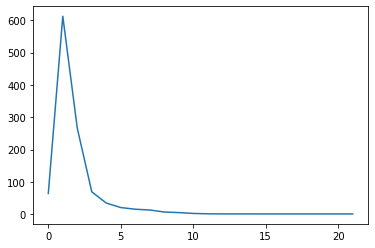

Epoch 1/50
2/2 - 7s - loss: 425.4662 - accuracy: 0.3057 - auc_2: 0.5319 - precision_2: 0.3057 - recall_2: 0.3057 - f1_score: 0.1887 - val_loss: 510.4892 - val_accuracy: 0.0800 - val_auc_2: 0.3867 - val_precision_2: 0.0800 - val_recall_2: 0.0800 - val_f1_score: 0.0370 - 7s/epoch - 4s/step
Epoch 2/50
2/2 - 2s - loss: 348.6672 - accuracy: 0.2314 - auc_2: 0.4900 - precision_2: 0.2314 - recall_2: 0.2314 - f1_score: 0.1431 - val_loss: 321.8248 - val_accuracy: 0.4000 - val_auc_2: 0.6000 - val_precision_2: 0.4000 - val_recall_2: 0.4000 - val_f1_score: 0.1429 - 2s/epoch - 1s/step
Epoch 3/50
2/2 - 2s - loss: 341.5357 - accuracy: 0.3629 - auc_2: 0.5752 - precision_2: 0.3629 - recall_2: 0.3629 - f1_score: 0.1331 - val_loss: 184.2346 - val_accuracy: 0.4000 - val_auc_2: 0.6000 - val_precision_2: 0.4000 - val_recall_2: 0.4000 - val_f1_score: 0.1429 - 2s/epoch - 1s/step
Epoch 4/50
2/2 - 2s - loss: 171.4359 - accuracy: 0.3657 - auc_2: 0.5798 - precision_2: 0.3657 - recall_2: 0.3657 - f1_score: 0.1361 -

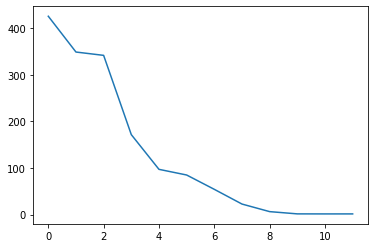

Epoch 1/50
2/2 - 7s - loss: 344.6086 - accuracy: 0.3629 - auc_3: 0.5930 - precision_3: 0.3629 - recall_3: 0.3629 - f1_score: 0.2228 - val_loss: 355.4538 - val_accuracy: 0.3086 - val_auc_3: 0.5390 - val_precision_3: 0.3086 - val_recall_3: 0.3086 - val_f1_score: 0.1179 - 7s/epoch - 4s/step
Epoch 2/50
2/2 - 2s - loss: 278.6599 - accuracy: 0.4257 - auc_3: 0.6171 - precision_3: 0.4257 - recall_3: 0.4257 - f1_score: 0.2139 - val_loss: 162.5497 - val_accuracy: 0.5714 - val_auc_3: 0.7143 - val_precision_3: 0.5714 - val_recall_3: 0.5714 - val_f1_score: 0.1818 - 2s/epoch - 1s/step
Epoch 3/50
2/2 - 2s - loss: 162.9012 - accuracy: 0.5057 - auc_3: 0.6705 - precision_3: 0.5057 - recall_3: 0.5057 - f1_score: 0.1679 - val_loss: 64.6176 - val_accuracy: 0.5714 - val_auc_3: 0.7143 - val_precision_3: 0.5714 - val_recall_3: 0.5714 - val_f1_score: 0.1818 - 2s/epoch - 1s/step
Epoch 4/50
2/2 - 2s - loss: 61.2621 - accuracy: 0.5057 - auc_3: 0.6696 - precision_3: 0.5057 - recall_3: 0.5057 - f1_score: 0.1679 - v

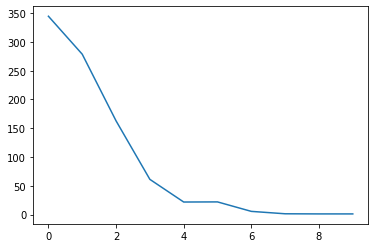

In [19]:
model1 = build_biConvLSTM(n_length, n_features, n_outputs, y_train.shape[1])
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model1 = build_biConvLSTM(n_features, n_length, n_outputs, y_train.shape[1])
    history = train(model1, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [20]:
member1 = KerasMember(name="BiLSTM", keras_model=model1,
    train_batches=(X_train, y_train),
    val_batches=(X_test, y_test))

#### Train CNN+LSTM

Epoch 1/50
2/2 - 3s - loss: 1.4073 - accuracy: 0.3143 - auc_5: 0.5389 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_score: 0.1944 - val_loss: 1.1593 - val_accuracy: 0.4914 - val_auc_5: 0.7872 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.1648 - 3s/epoch - 1s/step
Epoch 2/50
2/2 - 0s - loss: 1.1454 - accuracy: 0.5457 - auc_5: 0.8021 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_score: 0.1765 - val_loss: 1.0808 - val_accuracy: 0.4914 - val_auc_5: 0.8009 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.1648 - 224ms/epoch - 112ms/step
Epoch 3/50
2/2 - 0s - loss: 1.0696 - accuracy: 0.5457 - auc_5: 0.8117 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_score: 0.1765 - val_loss: 1.0512 - val_accuracy: 0.4914 - val_auc_5: 0.8009 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.1648 - 254ms/epoch - 127ms/step
Epoch 4/50
2/2 - 0s - loss: 1.0401 - accuracy: 0.5457 - auc_5: 0.8070 - precision_5: 

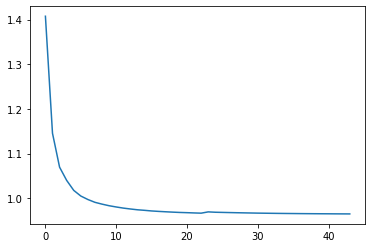

Epoch 1/50
2/2 - 2s - loss: 1.2773 - accuracy: 0.4829 - auc_6: 0.6796 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - f1_score: 0.1663 - val_loss: 1.0983 - val_accuracy: 0.5200 - val_auc_6: 0.8166 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_f1_score: 0.1711 - 2s/epoch - 1s/step
Epoch 2/50
2/2 - 0s - loss: 1.1018 - accuracy: 0.5314 - auc_6: 0.8123 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - f1_score: 0.1735 - val_loss: 1.0840 - val_accuracy: 0.5200 - val_auc_6: 0.8143 - val_precision_6: 0.5200 - val_recall_6: 0.0743 - val_f1_score: 0.1711 - 239ms/epoch - 120ms/step
Epoch 3/50
2/2 - 0s - loss: 1.0841 - accuracy: 0.5314 - auc_6: 0.8020 - precision_6: 0.5435 - recall_6: 0.0714 - f1_score: 0.1735 - val_loss: 1.0311 - val_accuracy: 0.5200 - val_auc_6: 0.8133 - val_precision_6: 0.5200 - val_recall_6: 0.5200 - val_f1_score: 0.1711 - 272ms/epoch - 136ms/step
Epoch 4/50
2/2 - 0s - loss: 1.0423 - accuracy: 0.5314 - auc_6: 0.8047 - precision_6: 0.5314 - recall_6: 0.531

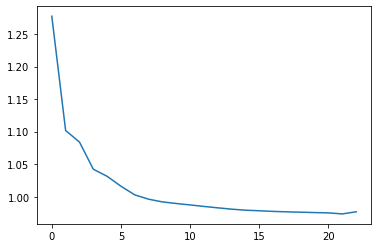

Epoch 1/50
2/2 - 3s - loss: 1.3000 - accuracy: 0.4714 - auc_7: 0.6604 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - f1_score: 0.1650 - val_loss: 1.1356 - val_accuracy: 0.5714 - val_auc_7: 0.8128 - val_precision_7: 0.5714 - val_recall_7: 0.5714 - val_f1_score: 0.1818 - 3s/epoch - 1s/step
Epoch 2/50
2/2 - 0s - loss: 1.1720 - accuracy: 0.5057 - auc_7: 0.8050 - precision_7: 0.5043 - recall_7: 0.5029 - f1_score: 0.1679 - val_loss: 1.0467 - val_accuracy: 0.5714 - val_auc_7: 0.8135 - val_precision_7: 0.5714 - val_recall_7: 0.5714 - val_f1_score: 0.1818 - 238ms/epoch - 119ms/step
Epoch 3/50
2/2 - 0s - loss: 1.0731 - accuracy: 0.5057 - auc_7: 0.8004 - precision_7: 0.5057 - recall_7: 0.5057 - f1_score: 0.1679 - val_loss: 1.0165 - val_accuracy: 0.5714 - val_auc_7: 0.8144 - val_precision_7: 0.5714 - val_recall_7: 0.5714 - val_f1_score: 0.1818 - 234ms/epoch - 117ms/step
Epoch 4/50
2/2 - 0s - loss: 1.0243 - accuracy: 0.5057 - auc_7: 0.8126 - precision_7: 0.5057 - recall_7: 0.5057 - f1_score: 0.

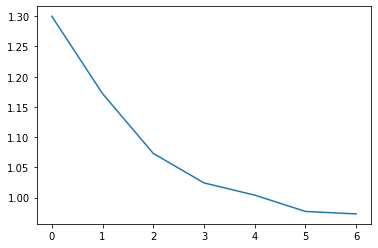

In [21]:
model2 = get_CNN(n_features, n_length, n_outputs, y_train.shape[1])
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model2 = get_CNN(n_features, n_length, n_outputs, y_train.shape[1])
    history = train(model2, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [22]:
member2 = KerasMember(name="CNN+LSTM", keras_model=model2,
    train_batches=(X_train, y_train),
    val_batches=(X_test, y_test))

#### Train ConvLSTM

Epoch 1/50
2/2 - 3s - loss: 90.8108 - accuracy: 0.1343 - auc_9: 0.4218 - precision_9: 0.1343 - recall_9: 0.1343 - f1_score: 0.0848 - val_loss: 398.2864 - val_accuracy: 0.4171 - val_auc_9: 0.6114 - val_precision_9: 0.4171 - val_recall_9: 0.4171 - val_f1_score: 0.1472 - 3s/epoch - 2s/step
Epoch 2/50
2/2 - 1s - loss: 405.5543 - accuracy: 0.3429 - auc_9: 0.5591 - precision_9: 0.3429 - recall_9: 0.3429 - f1_score: 0.1302 - val_loss: 252.6332 - val_accuracy: 0.0914 - val_auc_9: 0.3943 - val_precision_9: 0.0914 - val_recall_9: 0.0914 - val_f1_score: 0.0419 - 826ms/epoch - 413ms/step
Epoch 3/50
2/2 - 1s - loss: 208.8825 - accuracy: 0.0971 - auc_9: 0.3981 - precision_9: 0.0971 - recall_9: 0.0971 - f1_score: 0.0458 - val_loss: 101.8024 - val_accuracy: 0.4914 - val_auc_9: 0.6610 - val_precision_9: 0.4914 - val_recall_9: 0.4914 - val_f1_score: 0.1648 - 788ms/epoch - 394ms/step
Epoch 4/50
2/2 - 1s - loss: 100.1599 - accuracy: 0.5457 - auc_9: 0.6971 - precision_9: 0.5457 - recall_9: 0.5457 - f1_scor

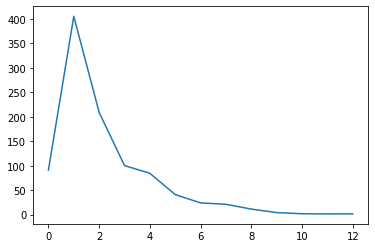

Epoch 1/50
2/2 - 3s - loss: 81.0301 - accuracy: 0.1571 - auc_10: 0.4366 - precision_10: 0.1571 - recall_10: 0.1571 - f1_score: 0.1079 - val_loss: 131.2541 - val_accuracy: 0.3371 - val_auc_10: 0.5602 - val_precision_10: 0.3371 - val_recall_10: 0.3371 - val_f1_score: 0.1488 - 3s/epoch - 2s/step
Epoch 2/50
2/2 - 1s - loss: 122.4874 - accuracy: 0.2571 - auc_10: 0.5049 - precision_10: 0.2571 - recall_10: 0.2571 - f1_score: 0.1623 - val_loss: 55.8816 - val_accuracy: 0.5200 - val_auc_10: 0.6800 - val_precision_10: 0.5200 - val_recall_10: 0.5200 - val_f1_score: 0.1711 - 814ms/epoch - 407ms/step
Epoch 3/50
2/2 - 1s - loss: 82.6937 - accuracy: 0.4857 - auc_10: 0.6586 - precision_10: 0.4857 - recall_10: 0.4857 - f1_score: 0.2341 - val_loss: 41.2507 - val_accuracy: 0.5371 - val_auc_10: 0.7063 - val_precision_10: 0.5371 - val_recall_10: 0.5371 - val_f1_score: 0.2045 - 789ms/epoch - 394ms/step
Epoch 4/50
2/2 - 1s - loss: 56.4458 - accuracy: 0.5371 - auc_10: 0.7029 - precision_10: 0.5371 - recall_10:

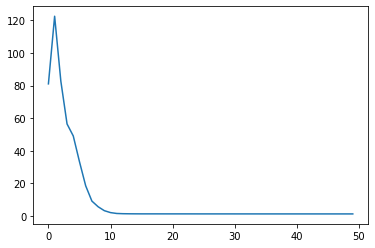

Epoch 1/50
2/2 - 4s - loss: 178.5619 - accuracy: 0.4800 - auc_11: 0.6540 - precision_11: 0.4800 - recall_11: 0.4800 - f1_score: 0.2440 - val_loss: 222.7059 - val_accuracy: 0.1314 - val_auc_11: 0.4184 - val_precision_11: 0.1314 - val_recall_11: 0.1314 - val_f1_score: 0.0949 - 4s/epoch - 2s/step
Epoch 2/50
2/2 - 1s - loss: 162.7960 - accuracy: 0.1829 - auc_11: 0.4415 - precision_11: 0.1829 - recall_11: 0.1829 - f1_score: 0.1315 - val_loss: 7.2759 - val_accuracy: 0.4914 - val_auc_11: 0.6858 - val_precision_11: 0.4914 - val_recall_11: 0.4914 - val_f1_score: 0.2488 - 755ms/epoch - 377ms/step
Epoch 3/50
2/2 - 1s - loss: 6.6077 - accuracy: 0.4429 - auc_11: 0.6623 - precision_11: 0.4413 - recall_11: 0.4400 - f1_score: 0.2117 - val_loss: 3.3748 - val_accuracy: 0.4743 - val_auc_11: 0.7102 - val_precision_11: 0.4872 - val_recall_11: 0.4343 - val_f1_score: 0.2405 - 806ms/epoch - 403ms/step
Epoch 4/50
2/2 - 1s - loss: 2.9694 - accuracy: 0.4400 - auc_11: 0.7013 - precision_11: 0.4477 - recall_11: 0.

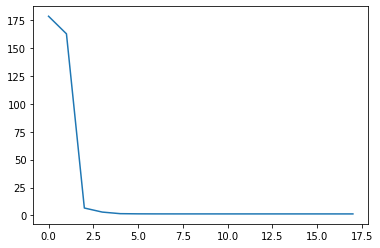

In [23]:
model3 = build_convLSTM(n_features, n_length, n_outputs, y_train.shape[1])
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model3 = build_convLSTM(n_features, n_length, n_outputs, y_train.shape[1])
    history = train(model3, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [24]:
member3 = KerasMember(name="ConvLSTM", keras_model=model3,
    train_batches=(X_train, y_train),
    val_batches=(X_test, y_test))

#### Train RCNN

Epoch 1/50
2/2 - 2s - loss: 2.5363 - accuracy: 0.4143 - auc_13: 0.6753 - precision_13: 0.4389 - recall_13: 0.2771 - f1_score: 0.2637 - val_loss: 1437.8741 - val_accuracy: 0.4914 - val_auc_13: 0.6610 - val_precision_13: 0.4914 - val_recall_13: 0.4914 - val_f1_score: 0.1648 - 2s/epoch - 1s/step
Epoch 2/50
2/2 - 1s - loss: 16.3595 - accuracy: 0.5629 - auc_13: 0.7209 - precision_13: 0.5629 - recall_13: 0.5629 - f1_score: 0.2223 - val_loss: 241.1645 - val_accuracy: 0.4914 - val_auc_13: 0.6610 - val_precision_13: 0.4914 - val_recall_13: 0.4914 - val_f1_score: 0.1648 - 892ms/epoch - 446ms/step
Epoch 3/50
2/2 - 1s - loss: 8.5797 - accuracy: 0.4514 - auc_13: 0.6850 - precision_13: 0.4553 - recall_13: 0.4514 - f1_score: 0.2600 - val_loss: 149.1561 - val_accuracy: 0.4914 - val_auc_13: 0.6610 - val_precision_13: 0.4914 - val_recall_13: 0.4914 - val_f1_score: 0.1648 - 864ms/epoch - 432ms/step
Epoch 4/50
2/2 - 1s - loss: 3.5950 - accuracy: 0.5371 - auc_13: 0.7793 - precision_13: 0.5449 - recall_13: 

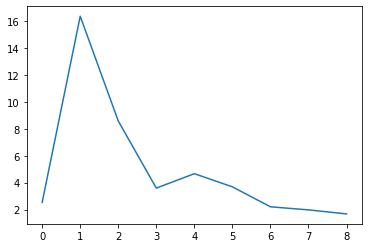

Epoch 1/50
2/2 - 2s - loss: 3.9191 - accuracy: 0.3229 - auc_14: 0.5781 - precision_14: 0.3571 - recall_14: 0.1857 - f1_score: 0.1891 - val_loss: 1251.5942 - val_accuracy: 0.4000 - val_auc_14: 0.6000 - val_precision_14: 0.4000 - val_recall_14: 0.4000 - val_f1_score: 0.1429 - 2s/epoch - 1s/step
Epoch 2/50
2/2 - 1s - loss: 20.6666 - accuracy: 0.3657 - auc_14: 0.5924 - precision_14: 0.3657 - recall_14: 0.3657 - f1_score: 0.1361 - val_loss: 303.7574 - val_accuracy: 0.5200 - val_auc_14: 0.6800 - val_precision_14: 0.5200 - val_recall_14: 0.5200 - val_f1_score: 0.1711 - 861ms/epoch - 430ms/step
Epoch 3/50
2/2 - 1s - loss: 8.0434 - accuracy: 0.5457 - auc_14: 0.7674 - precision_14: 0.5457 - recall_14: 0.5457 - f1_score: 0.2116 - val_loss: 329.4991 - val_accuracy: 0.5200 - val_auc_14: 0.6800 - val_precision_14: 0.5200 - val_recall_14: 0.5200 - val_f1_score: 0.1711 - 888ms/epoch - 444ms/step
Epoch 4/50
2/2 - 1s - loss: 7.1905 - accuracy: 0.5686 - auc_14: 0.7606 - precision_14: 0.5681 - recall_14: 

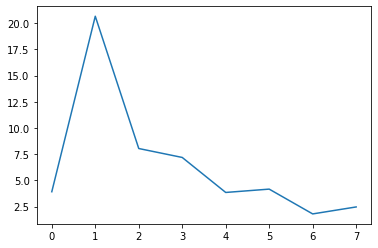

Epoch 1/50
2/2 - 2s - loss: 6.4847 - accuracy: 0.4029 - auc_15: 0.6483 - precision_15: 0.4696 - recall_15: 0.2429 - f1_score: 0.2369 - val_loss: 548.5832 - val_accuracy: 0.5714 - val_auc_15: 0.7143 - val_precision_15: 0.5714 - val_recall_15: 0.5714 - val_f1_score: 0.1818 - 2s/epoch - 1s/step
Epoch 2/50
2/2 - 1s - loss: 9.4408 - accuracy: 0.5029 - auc_15: 0.6988 - precision_15: 0.5043 - recall_15: 0.5000 - f1_score: 0.3090 - val_loss: 659.3768 - val_accuracy: 0.3086 - val_auc_15: 0.5390 - val_precision_15: 0.3086 - val_recall_15: 0.3086 - val_f1_score: 0.1179 - 908ms/epoch - 454ms/step
Epoch 3/50
2/2 - 1s - loss: 10.4063 - accuracy: 0.4114 - auc_15: 0.6576 - precision_15: 0.4104 - recall_15: 0.4057 - f1_score: 0.2432 - val_loss: 148.2554 - val_accuracy: 0.5714 - val_auc_15: 0.7143 - val_precision_15: 0.5714 - val_recall_15: 0.5714 - val_f1_score: 0.1818 - 878ms/epoch - 439ms/step
Epoch 4/50
2/2 - 1s - loss: 3.3910 - accuracy: 0.5171 - auc_15: 0.7770 - precision_15: 0.5220 - recall_15: 0

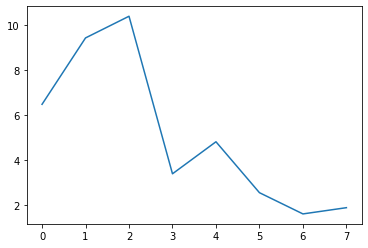

In [25]:
model4 = build_RCNN(n_features, n_length, n_outputs, y_train.shape[1])
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model4 = build_RCNN(n_features, n_length, n_outputs, y_train.shape[1])
    history = train(model4, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [26]:
member4 = KerasMember(name="RCNN", keras_model=model4,
    train_batches=(X_train, y_train),
    val_batches=(X_test, y_test))

#### Stacking Ensemble

In [27]:
skeleton_stackEnsemble = StackEnsemble()
skeleton_stackEnsemble.add_member(member1)
skeleton_stackEnsemble.add_member(member2)
skeleton_stackEnsemble.add_member(member3)
skeleton_stackEnsemble.add_member(member4)

In [28]:
skeleton_stackEnsemble.fit()

RandomForestClassifier(max_depth=4, n_jobs=20)

#### Dirichlet Markov Ensemble

In [29]:
skeleton_dirichletEnsemble = DirichletEnsemble(N=2000 * 4)
skeleton_dirichletEnsemble.add_member(member1)
skeleton_dirichletEnsemble.add_member(member2)
skeleton_dirichletEnsemble.add_member(member3)
skeleton_dirichletEnsemble.add_member(member4)

In [30]:
skeleton_dirichletEnsemble.fit()

### 1.2 Face modality (Action units)

#### About the data

In [31]:
X_train, X_test, y_train, y_test, feature_names, classes = load_dataset('processed', 'AUs')
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(193, 1, 350, 10) (193, 3)
(42, 1, 350, 10) (42, 3)


In [32]:
feature_names

['confidence',
 'AU04_r',
 'AU06_r',
 'AU07_r',
 'AU09_r',
 'AU10_r',
 'AU04_c',
 'AU06_c',
 'AU07_c',
 'AU09_c']

#### Train BiLSTM

Epoch 1/50
1/1 - 6s - loss: 1.0908 - accuracy: 0.5000 - auc_17: 0.7072 - precision_17: 0.0000e+00 - recall_17: 0.0000e+00 - f1_score: 0.3413 - val_loss: 1.3534 - val_accuracy: 0.6000 - val_auc_17: 0.7662 - val_precision_17: 0.6094 - val_recall_17: 0.6000 - val_f1_score: 0.2500 - 6s/epoch - 6s/step
Epoch 2/50
1/1 - 1s - loss: 1.2705 - accuracy: 0.5781 - auc_17: 0.7738 - precision_17: 0.5714 - recall_17: 0.5625 - f1_score: 0.2442 - val_loss: 1.4407 - val_accuracy: 0.3077 - val_auc_17: 0.6220 - val_precision_17: 0.3125 - val_recall_17: 0.3077 - val_f1_score: 0.1569 - 807ms/epoch - 807ms/step
Epoch 3/50
1/1 - 1s - loss: 1.2765 - accuracy: 0.3594 - auc_17: 0.6758 - precision_17: 0.3651 - recall_17: 0.3594 - f1_score: 0.1762 - val_loss: 1.1140 - val_accuracy: 0.5538 - val_auc_17: 0.7602 - val_precision_17: 0.5714 - val_recall_17: 0.5538 - val_f1_score: 0.3796 - 828ms/epoch - 828ms/step
Epoch 4/50
1/1 - 1s - loss: 0.9450 - accuracy: 0.6406 - auc_17: 0.8160 - precision_17: 0.6435 - recall_17: 

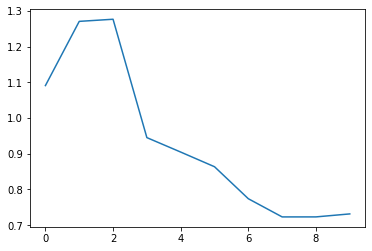

Epoch 1/50
1/1 - 6s - loss: 1.1100 - accuracy: 0.0775 - auc_18: 0.3597 - precision_18: 0.0000e+00 - recall_18: 0.0000e+00 - f1_score: 0.0528 - val_loss: 1.3674 - val_accuracy: 0.6406 - val_auc_18: 0.7499 - val_precision_18: 0.6406 - val_recall_18: 0.6406 - val_f1_score: 0.2603 - 6s/epoch - 6s/step
Epoch 2/50
1/1 - 1s - loss: 1.5341 - accuracy: 0.5581 - auc_18: 0.7154 - precision_18: 0.5600 - recall_18: 0.5426 - f1_score: 0.2388 - val_loss: 0.8413 - val_accuracy: 0.6406 - val_auc_18: 0.7918 - val_precision_18: 0.6393 - val_recall_18: 0.6094 - val_f1_score: 0.2603 - 890ms/epoch - 890ms/step
Epoch 3/50
1/1 - 1s - loss: 0.8624 - accuracy: 0.5581 - auc_18: 0.7878 - precision_18: 0.5841 - recall_18: 0.5116 - f1_score: 0.2388 - val_loss: 1.1702 - val_accuracy: 0.3281 - val_auc_18: 0.6079 - val_precision_18: 0.3333 - val_recall_18: 0.3125 - val_f1_score: 0.1874 - 822ms/epoch - 822ms/step
Epoch 4/50
1/1 - 1s - loss: 1.0828 - accuracy: 0.3721 - auc_18: 0.6681 - precision_18: 0.3675 - recall_18: 

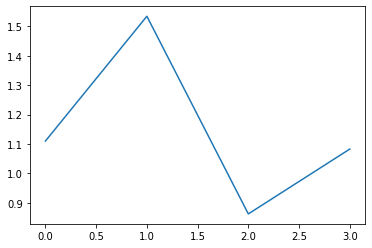

Epoch 1/50
1/1 - 5s - loss: 1.0929 - accuracy: 0.4806 - auc_19: 0.6137 - precision_19: 0.0000e+00 - recall_19: 0.0000e+00 - f1_score: 0.2615 - val_loss: 1.5996 - val_accuracy: 0.5156 - val_auc_19: 0.7231 - val_precision_19: 0.5000 - val_recall_19: 0.4844 - val_f1_score: 0.2268 - 5s/epoch - 5s/step
Epoch 2/50
1/1 - 1s - loss: 1.4022 - accuracy: 0.6202 - auc_19: 0.7852 - precision_19: 0.6250 - recall_19: 0.6202 - f1_score: 0.2552 - val_loss: 1.0450 - val_accuracy: 0.5156 - val_auc_19: 0.7449 - val_precision_19: 0.5000 - val_recall_19: 0.4688 - val_f1_score: 0.2268 - 806ms/epoch - 806ms/step
Epoch 3/50
1/1 - 1s - loss: 0.9884 - accuracy: 0.6202 - auc_19: 0.8300 - precision_19: 0.6299 - recall_19: 0.6202 - f1_score: 0.2552 - val_loss: 1.0757 - val_accuracy: 0.4219 - val_auc_19: 0.6770 - val_precision_19: 0.4000 - val_recall_19: 0.3438 - val_f1_score: 0.2276 - 860ms/epoch - 860ms/step
Epoch 4/50
1/1 - 1s - loss: 1.0716 - accuracy: 0.4109 - auc_19: 0.6887 - precision_19: 0.3984 - recall_19: 

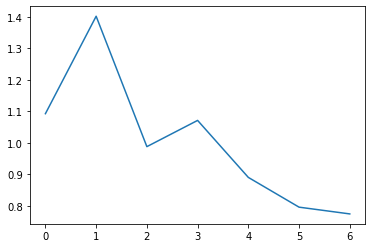

In [33]:
model1 = build_biConvLSTM(n_length, n_features, n_outputs, y_train.shape[1])
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model1 = build_biConvLSTM(n_features, n_length, n_outputs, y_train.shape[1])
    history = train(model1, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [34]:
member1 = KerasMember(name="BiLSTM", keras_model=model1,
    train_batches=(X_train, y_train),
    val_batches=(X_test, y_test))

#### Train CNN+LSTM

Epoch 1/50
1/1 - 2s - loss: 1.1334 - accuracy: 0.0781 - auc_21: 0.3161 - precision_21: 0.0000e+00 - recall_21: 0.0000e+00 - f1_score: 0.0609 - val_loss: 0.9233 - val_accuracy: 0.6000 - val_auc_21: 0.7572 - val_precision_21: 0.5968 - val_recall_21: 0.5692 - val_f1_score: 0.2500 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 0.9289 - accuracy: 0.5781 - auc_21: 0.7666 - precision_21: 0.5826 - recall_21: 0.5234 - f1_score: 0.2442 - val_loss: 0.9059 - val_accuracy: 0.6154 - val_auc_21: 0.7714 - val_precision_21: 0.5455 - val_recall_21: 0.0923 - val_f1_score: 0.3462 - 109ms/epoch - 109ms/step
Epoch 3/50
1/1 - 0s - loss: 0.8759 - accuracy: 0.6562 - auc_21: 0.8123 - precision_21: 0.8333 - recall_21: 0.1562 - f1_score: 0.3978 - val_loss: 0.8798 - val_accuracy: 0.6000 - val_auc_21: 0.7827 - val_precision_21: 0.6522 - val_recall_21: 0.4615 - val_f1_score: 0.2500 - 89ms/epoch - 89ms/step
Epoch 4/50
1/1 - 0s - loss: 0.8328 - accuracy: 0.6094 - auc_21: 0.8190 - precision_21: 0.7176 - recall_21: 0.

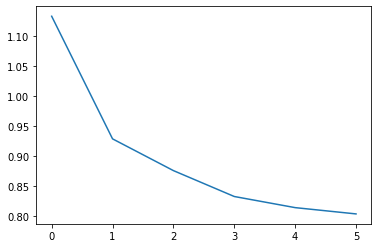

Epoch 1/50
1/1 - 3s - loss: 1.1062 - accuracy: 0.3178 - auc_22: 0.4589 - precision_22: 0.0000e+00 - recall_22: 0.0000e+00 - f1_score: 0.2572 - val_loss: 0.8211 - val_accuracy: 0.6406 - val_auc_22: 0.8011 - val_precision_22: 0.6393 - val_recall_22: 0.6094 - val_f1_score: 0.2603 - 3s/epoch - 3s/step
Epoch 2/50
1/1 - 0s - loss: 0.8892 - accuracy: 0.5581 - auc_22: 0.7704 - precision_22: 0.5620 - recall_22: 0.5271 - f1_score: 0.2388 - val_loss: 0.9151 - val_accuracy: 0.3906 - val_auc_22: 0.6516 - val_precision_22: 0.3784 - val_recall_22: 0.2188 - val_f1_score: 0.2496 - 103ms/epoch - 103ms/step
Epoch 3/50
1/1 - 0s - loss: 0.9072 - accuracy: 0.4341 - auc_22: 0.7207 - precision_22: 0.4783 - recall_22: 0.3411 - f1_score: 0.2839 - val_loss: 0.8272 - val_accuracy: 0.6250 - val_auc_22: 0.7996 - val_precision_22: 0.6429 - val_recall_22: 0.5625 - val_f1_score: 0.2564 - 98ms/epoch - 98ms/step


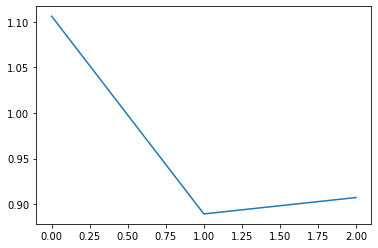

Epoch 1/50
1/1 - 2s - loss: 1.1003 - accuracy: 0.3953 - auc_23: 0.4981 - precision_23: 0.0000e+00 - recall_23: 0.0000e+00 - f1_score: 0.3126 - val_loss: 1.0216 - val_accuracy: 0.5156 - val_auc_23: 0.7401 - val_precision_23: 0.5082 - val_recall_23: 0.4844 - val_f1_score: 0.2268 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 0.8823 - accuracy: 0.6202 - auc_23: 0.8018 - precision_23: 0.6250 - recall_23: 0.6202 - f1_score: 0.2552 - val_loss: 0.9074 - val_accuracy: 0.5156 - val_auc_23: 0.7256 - val_precision_23: 0.5000 - val_recall_23: 0.4688 - val_f1_score: 0.2268 - 91ms/epoch - 91ms/step
Epoch 3/50
1/1 - 0s - loss: 0.8458 - accuracy: 0.6202 - auc_23: 0.8079 - precision_23: 0.6299 - recall_23: 0.6202 - f1_score: 0.2552 - val_loss: 0.9040 - val_accuracy: 0.5156 - val_auc_23: 0.7324 - val_precision_23: 0.5088 - val_recall_23: 0.4531 - val_f1_score: 0.2268 - 92ms/epoch - 92ms/step
Epoch 4/50
1/1 - 0s - loss: 0.8272 - accuracy: 0.6202 - auc_23: 0.8171 - precision_23: 0.6504 - recall_23: 0.62

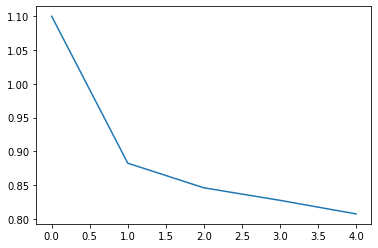

In [35]:
model2 = get_CNN(n_features, n_length, n_outputs, y_train.shape[1])
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model2 = get_CNN(n_features, n_length, n_outputs, y_train.shape[1])
    history = train(model2, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [36]:
member2 = KerasMember(name="CNN+LSTM", keras_model=model2,
    train_batches=(X_train, y_train),
    val_batches=(X_test, y_test))

#### Train ConvLSTM

Epoch 1/50
1/1 - 3s - loss: 1.0874 - accuracy: 0.5547 - auc_25: 0.6974 - precision_25: 0.0000e+00 - recall_25: 0.0000e+00 - f1_score: 0.3020 - val_loss: 0.9520 - val_accuracy: 0.6000 - val_auc_25: 0.7608 - val_precision_25: 0.5968 - val_recall_25: 0.5692 - val_f1_score: 0.2500 - 3s/epoch - 3s/step
Epoch 2/50
1/1 - 0s - loss: 0.9076 - accuracy: 0.5781 - auc_25: 0.7711 - precision_25: 0.5862 - recall_25: 0.5312 - f1_score: 0.2442 - val_loss: 0.9275 - val_accuracy: 0.5692 - val_auc_25: 0.7732 - val_precision_25: 0.6512 - val_recall_25: 0.4308 - val_f1_score: 0.2894 - 292ms/epoch - 292ms/step
Epoch 3/50
1/1 - 0s - loss: 0.8623 - accuracy: 0.5938 - auc_25: 0.7954 - precision_25: 0.6667 - recall_25: 0.4219 - f1_score: 0.3299 - val_loss: 0.9356 - val_accuracy: 0.5692 - val_auc_25: 0.7775 - val_precision_25: 0.6667 - val_recall_25: 0.4000 - val_f1_score: 0.3075 - 320ms/epoch - 320ms/step
Epoch 4/50
1/1 - 0s - loss: 0.8478 - accuracy: 0.6484 - auc_25: 0.8126 - precision_25: 0.6941 - recall_25: 

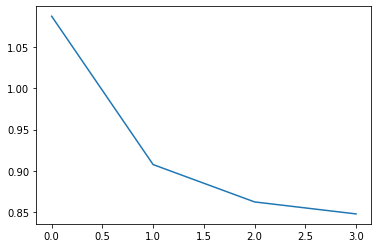

Epoch 1/50
1/1 - 3s - loss: 1.1005 - accuracy: 0.3411 - auc_26: 0.5052 - precision_26: 0.0000e+00 - recall_26: 0.0000e+00 - f1_score: 0.3205 - val_loss: 0.8622 - val_accuracy: 0.6406 - val_auc_26: 0.7842 - val_precision_26: 0.6333 - val_recall_26: 0.5938 - val_f1_score: 0.2603 - 3s/epoch - 3s/step
Epoch 2/50
1/1 - 0s - loss: 0.9344 - accuracy: 0.5581 - auc_26: 0.7522 - precision_26: 0.5818 - recall_26: 0.4961 - f1_score: 0.2388 - val_loss: 0.8471 - val_accuracy: 0.6406 - val_auc_26: 0.7875 - val_precision_26: 0.6271 - val_recall_26: 0.5781 - val_f1_score: 0.2603 - 303ms/epoch - 303ms/step
Epoch 3/50
1/1 - 0s - loss: 0.8725 - accuracy: 0.5581 - auc_26: 0.7825 - precision_26: 0.5849 - recall_26: 0.4806 - f1_score: 0.2388 - val_loss: 0.8694 - val_accuracy: 0.5938 - val_auc_26: 0.7675 - val_precision_26: 0.6364 - val_recall_26: 0.4375 - val_f1_score: 0.2773 - 271ms/epoch - 271ms/step
Epoch 4/50
1/1 - 0s - loss: 0.8593 - accuracy: 0.5969 - auc_26: 0.7940 - precision_26: 0.6962 - recall_26: 

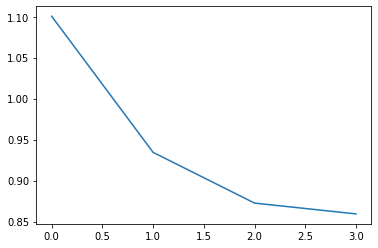

Epoch 1/50
1/1 - 3s - loss: 1.1065 - accuracy: 0.2868 - auc_27: 0.3858 - precision_27: 0.0000e+00 - recall_27: 0.0000e+00 - f1_score: 0.2161 - val_loss: 1.0144 - val_accuracy: 0.5156 - val_auc_27: 0.7230 - val_precision_27: 0.5172 - val_recall_27: 0.4688 - val_f1_score: 0.2268 - 3s/epoch - 3s/step
Epoch 2/50
1/1 - 0s - loss: 0.8881 - accuracy: 0.6202 - auc_27: 0.7845 - precision_27: 0.6210 - recall_27: 0.5969 - f1_score: 0.2552 - val_loss: 0.9211 - val_accuracy: 0.5156 - val_auc_27: 0.7239 - val_precision_27: 0.5400 - val_recall_27: 0.4219 - val_f1_score: 0.2268 - 304ms/epoch - 304ms/step
Epoch 3/50
1/1 - 0s - loss: 0.8397 - accuracy: 0.6202 - auc_27: 0.8211 - precision_27: 0.6364 - recall_27: 0.5969 - f1_score: 0.2552 - val_loss: 0.9269 - val_accuracy: 0.5156 - val_auc_27: 0.7252 - val_precision_27: 0.5400 - val_recall_27: 0.4219 - val_f1_score: 0.2268 - 262ms/epoch - 262ms/step
Epoch 4/50
1/1 - 0s - loss: 0.8173 - accuracy: 0.6512 - auc_27: 0.8356 - precision_27: 0.6695 - recall_27: 

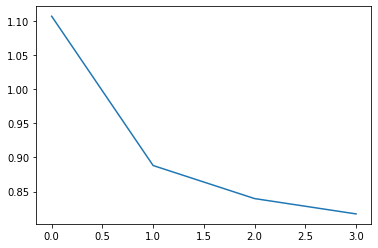

In [37]:
model3 = build_convLSTM(n_features, n_length, n_outputs, y_train.shape[1])
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model3 = build_convLSTM(n_features, n_length, n_outputs, y_train.shape[1])
    history = train(model3, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [38]:
member3 = KerasMember(name="ConvLSTM", keras_model=model3,
    train_batches=(X_train, y_train),
    val_batches=(X_test, y_test))

#### Train RCNN

Epoch 1/50
1/1 - 2s - loss: 1.9530 - accuracy: 0.1875 - auc_29: 0.3949 - precision_29: 0.2000 - recall_29: 0.1719 - f1_score: 0.1876 - val_loss: 3.4043 - val_accuracy: 0.6000 - val_auc_29: 0.7556 - val_precision_29: 0.6094 - val_recall_29: 0.6000 - val_f1_score: 0.2500 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 11.2472 - accuracy: 0.5781 - auc_29: 0.6933 - precision_29: 0.5781 - recall_29: 0.5781 - f1_score: 0.2442 - val_loss: 4.5333 - val_accuracy: 0.3077 - val_auc_29: 0.5927 - val_precision_29: 0.3125 - val_recall_29: 0.3077 - val_f1_score: 0.1587 - 327ms/epoch - 327ms/step
Epoch 3/50
1/1 - 0s - loss: 16.1100 - accuracy: 0.3828 - auc_29: 0.5728 - precision_29: 0.3828 - recall_29: 0.3828 - f1_score: 0.2053 - val_loss: 3.3722 - val_accuracy: 0.6000 - val_auc_29: 0.7797 - val_precision_29: 0.6094 - val_recall_29: 0.6000 - val_f1_score: 0.2500 - 355ms/epoch - 355ms/step
Epoch 4/50
1/1 - 0s - loss: 7.1437 - accuracy: 0.7188 - auc_29: 0.8446 - precision_29: 0.7188 - recall_29: 0.7188

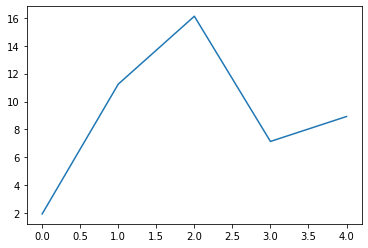

Epoch 1/50
1/1 - 2s - loss: 1.7851 - accuracy: 0.2558 - auc_30: 0.4404 - precision_30: 0.2600 - recall_30: 0.2016 - f1_score: 0.2088 - val_loss: 1.9311 - val_accuracy: 0.6406 - val_auc_30: 0.8015 - val_precision_30: 0.6406 - val_recall_30: 0.6406 - val_f1_score: 0.2603 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 6.8009 - accuracy: 0.6047 - auc_30: 0.7794 - precision_30: 0.6047 - recall_30: 0.6047 - f1_score: 0.3630 - val_loss: 5.1274 - val_accuracy: 0.2969 - val_auc_30: 0.5670 - val_precision_30: 0.2969 - val_recall_30: 0.2969 - val_f1_score: 0.1526 - 369ms/epoch - 369ms/step
Epoch 3/50
1/1 - 0s - loss: 20.8638 - accuracy: 0.3643 - auc_30: 0.5233 - precision_30: 0.3643 - recall_30: 0.3643 - f1_score: 0.1780 - val_loss: 2.9518 - val_accuracy: 0.6406 - val_auc_30: 0.7884 - val_precision_30: 0.6406 - val_recall_30: 0.6406 - val_f1_score: 0.2603 - 314ms/epoch - 314ms/step


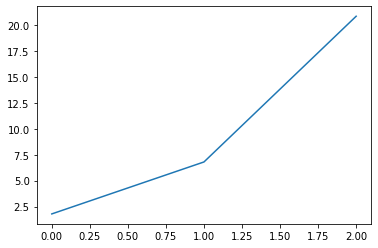

Epoch 1/50
1/1 - 2s - loss: 1.7850 - accuracy: 0.2713 - auc_31: 0.4344 - precision_31: 0.2673 - recall_31: 0.2093 - f1_score: 0.2271 - val_loss: 4.0708 - val_accuracy: 0.5156 - val_auc_31: 0.6762 - val_precision_31: 0.5000 - val_recall_31: 0.4844 - val_f1_score: 0.2268 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 12.9075 - accuracy: 0.6202 - auc_31: 0.7327 - precision_31: 0.6202 - recall_31: 0.6202 - f1_score: 0.2552 - val_loss: 4.1363 - val_accuracy: 0.4219 - val_auc_31: 0.6608 - val_precision_31: 0.4355 - val_recall_31: 0.4219 - val_f1_score: 0.2000 - 340ms/epoch - 340ms/step
Epoch 3/50
1/1 - 0s - loss: 17.1476 - accuracy: 0.3566 - auc_31: 0.5335 - precision_31: 0.3566 - recall_31: 0.3566 - f1_score: 0.2151 - val_loss: 2.7732 - val_accuracy: 0.5000 - val_auc_31: 0.7274 - val_precision_31: 0.5000 - val_recall_31: 0.4844 - val_f1_score: 0.2604 - 312ms/epoch - 312ms/step
Epoch 4/50
1/1 - 0s - loss: 7.5207 - accuracy: 0.6899 - auc_31: 0.8200 - precision_31: 0.6899 - recall_31: 0.6899

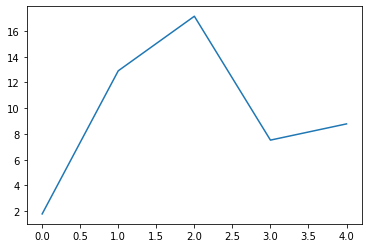

In [39]:
model4 = build_RCNN(n_features, n_length, n_outputs, y_train.shape[1])
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model4 = build_RCNN(n_features, n_length, n_outputs, y_train.shape[1])
    history = train(model4, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [40]:
member4 = KerasMember(name="RCNN", keras_model=model4,
    train_batches=(X_train, y_train),
    val_batches=(X_test, y_test))

#### Stacking Ensemble

In [41]:
facial_stackEnsemble = StackEnsemble()
facial_stackEnsemble.add_member(member1)
facial_stackEnsemble.add_member(member2)
facial_stackEnsemble.add_member(member3)
facial_stackEnsemble.add_member(member4)

In [42]:
facial_stackEnsemble.fit()

RandomForestClassifier(max_depth=4, n_jobs=20)

#### Dirichlet Markov Ensemble

In [43]:
facial_dirichletEnsemble = DirichletEnsemble(N=2000 * 4)
facial_dirichletEnsemble.add_member(member1)
facial_dirichletEnsemble.add_member(member2)
facial_dirichletEnsemble.add_member(member3)
facial_dirichletEnsemble.add_member(member4)

In [44]:
facial_dirichletEnsemble.fit()

## 2. Early Fusion - Fusion is performed at feature level

Early fusion concatenates features at the input level, then all the work is on the classifier. 

My initial assumption is that perhaps early fusion is not the best idea because the face modality is missing about half the times (OpenFace could not capture facial action units from the videos), which makes the dataset smaller. 
I did not replace the missing facial values because I thought null values will bring no benefit (I assume?) and adding for example zero would mean the absence of action units which I'm afraid might actually "trick" the model in the case where a person has pain and the facial modality was not available because of technical issues, not because of an actual lack of pain.

### About the data

In [45]:
X_train, X_test, y_train, y_test = apply_early_fusion('processed')
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(193, 1, 350, 48) (193, 3)
(42, 1, 350, 48) (42, 3)


### Train BiLSTM (with early fusion)

Epoch 1/50
1/1 - 6s - loss: 47.8269 - accuracy: 0.0625 - auc_33: 0.2969 - precision_33: 0.0625 - recall_33: 0.0625 - f1_score: 0.0392 - val_loss: 476.2050 - val_accuracy: 0.6000 - val_auc_33: 0.7000 - val_precision_33: 0.6000 - val_recall_33: 0.6000 - val_f1_score: 0.2500 - 6s/epoch - 6s/step
Epoch 2/50
1/1 - 1s - loss: 401.6521 - accuracy: 0.5781 - auc_33: 0.6836 - precision_33: 0.5781 - recall_33: 0.5781 - f1_score: 0.2442 - val_loss: 1396.0190 - val_accuracy: 0.3077 - val_auc_33: 0.4808 - val_precision_33: 0.3077 - val_recall_33: 0.3077 - val_f1_score: 0.1569 - 904ms/epoch - 904ms/step
Epoch 3/50
1/1 - 1s - loss: 1175.2172 - accuracy: 0.3594 - auc_33: 0.5195 - precision_33: 0.3594 - recall_33: 0.3594 - f1_score: 0.1762 - val_loss: 659.4987 - val_accuracy: 0.3077 - val_auc_33: 0.4808 - val_precision_33: 0.3077 - val_recall_33: 0.3077 - val_f1_score: 0.1569 - 863ms/epoch - 863ms/step


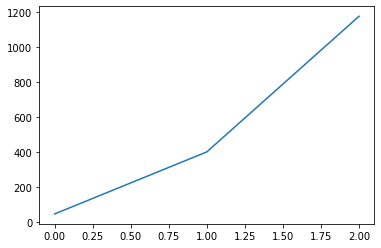

Epoch 1/50
1/1 - 6s - loss: 15.1767 - accuracy: 0.5349 - auc_34: 0.6605 - precision_34: 0.5349 - recall_34: 0.5349 - f1_score: 0.2452 - val_loss: 1442.1512 - val_accuracy: 0.2969 - val_auc_34: 0.4727 - val_precision_34: 0.2969 - val_recall_34: 0.2969 - val_f1_score: 0.1526 - 6s/epoch - 6s/step
Epoch 2/50
1/1 - 1s - loss: 1320.0411 - accuracy: 0.3643 - auc_34: 0.5233 - precision_34: 0.3643 - recall_34: 0.3643 - f1_score: 0.1780 - val_loss: 367.9119 - val_accuracy: 0.2031 - val_auc_34: 0.3820 - val_precision_34: 0.2031 - val_recall_34: 0.2031 - val_f1_score: 0.1534 - 940ms/epoch - 940ms/step
Epoch 3/50
1/1 - 1s - loss: 323.3865 - accuracy: 0.3566 - auc_34: 0.4857 - precision_34: 0.3566 - recall_34: 0.3566 - f1_score: 0.2770 - val_loss: 59.5184 - val_accuracy: 0.0781 - val_auc_34: 0.3086 - val_precision_34: 0.0781 - val_recall_34: 0.0781 - val_f1_score: 0.0557 - 882ms/epoch - 882ms/step
Epoch 4/50
1/1 - 1s - loss: 63.9921 - accuracy: 0.0698 - auc_34: 0.3034 - precision_34: 0.0698 - recall

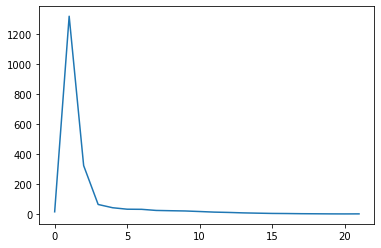

Epoch 1/50
1/1 - 6s - loss: 8.6504 - accuracy: 0.3566 - auc_35: 0.5393 - precision_35: 0.3566 - recall_35: 0.3566 - f1_score: 0.3157 - val_loss: 1567.0229 - val_accuracy: 0.5156 - val_auc_35: 0.6367 - val_precision_35: 0.5156 - val_recall_35: 0.5156 - val_f1_score: 0.2268 - 6s/epoch - 6s/step
Epoch 2/50
1/1 - 1s - loss: 1199.8846 - accuracy: 0.6202 - auc_35: 0.7151 - precision_35: 0.6202 - recall_35: 0.6202 - f1_score: 0.2552 - val_loss: 865.3268 - val_accuracy: 0.5156 - val_auc_35: 0.6367 - val_precision_35: 0.5156 - val_recall_35: 0.5156 - val_f1_score: 0.2268 - 866ms/epoch - 866ms/step
Epoch 3/50
1/1 - 1s - loss: 643.2052 - accuracy: 0.6202 - auc_35: 0.7151 - precision_35: 0.6202 - recall_35: 0.6202 - f1_score: 0.2552 - val_loss: 626.1336 - val_accuracy: 0.0625 - val_auc_35: 0.2969 - val_precision_35: 0.0625 - val_recall_35: 0.0625 - val_f1_score: 0.0392 - 877ms/epoch - 877ms/step
Epoch 4/50
1/1 - 1s - loss: 543.2431 - accuracy: 0.0775 - auc_35: 0.3081 - precision_35: 0.0775 - recal

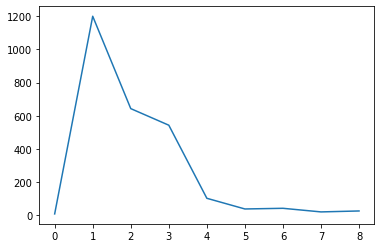

In [46]:
model1 = build_biConvLSTM(n_length, n_features, n_outputs, y_train.shape[1])
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model1 = build_biConvLSTM(n_features, n_length, n_outputs, y_train.shape[1])
    history = train(model1, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [47]:
member1 = KerasMember(name="BiLSTM", keras_model=model1,
    train_batches=(X_train, y_train),
    val_batches=(X_test, y_test))

### Train CNN+LSTM (with early fusion)

Epoch 1/50
1/1 - 2s - loss: 1.0934 - accuracy: 0.5312 - auc_37: 0.6256 - precision_37: 0.7368 - recall_37: 0.1094 - f1_score: 0.2921 - val_loss: 0.9807 - val_accuracy: 0.6000 - val_auc_37: 0.6528 - val_precision_37: 0.6000 - val_recall_37: 0.6000 - val_f1_score: 0.2500 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 1.0188 - accuracy: 0.5781 - auc_37: 0.6021 - precision_37: 0.5781 - recall_37: 0.5781 - f1_score: 0.2442 - val_loss: 0.9493 - val_accuracy: 0.6000 - val_auc_37: 0.7530 - val_precision_37: 0.6000 - val_recall_37: 0.6000 - val_f1_score: 0.2500 - 155ms/epoch - 155ms/step
Epoch 3/50
1/1 - 0s - loss: 0.9752 - accuracy: 0.5781 - auc_37: 0.7555 - precision_37: 0.5781 - recall_37: 0.5781 - f1_score: 0.2442 - val_loss: 0.9511 - val_accuracy: 0.6000 - val_auc_37: 0.7508 - val_precision_37: 0.6000 - val_recall_37: 0.6000 - val_f1_score: 0.2500 - 106ms/epoch - 106ms/step
Epoch 4/50
1/1 - 0s - loss: 0.9774 - accuracy: 0.5781 - auc_37: 0.7578 - precision_37: 0.5781 - recall_37: 0.5781 -

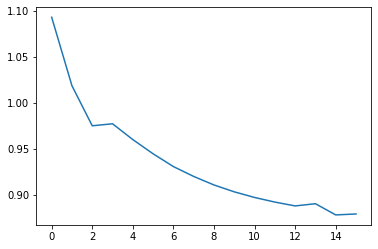

Epoch 1/50
1/1 - 2s - loss: 1.2417 - accuracy: 0.1628 - auc_38: 0.2870 - precision_38: 0.0000e+00 - recall_38: 0.0000e+00 - f1_score: 0.1535 - val_loss: 1.0665 - val_accuracy: 0.6094 - val_auc_38: 0.6698 - val_precision_38: 0.0000e+00 - val_recall_38: 0.0000e+00 - val_f1_score: 0.2653 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 1.0800 - accuracy: 0.5349 - auc_38: 0.5882 - precision_38: 0.0000e+00 - recall_38: 0.0000e+00 - f1_score: 0.2707 - val_loss: 1.0139 - val_accuracy: 0.6406 - val_auc_38: 0.7937 - val_precision_38: 0.0000e+00 - val_recall_38: 0.0000e+00 - val_f1_score: 0.2603 - 137ms/epoch - 137ms/step
Epoch 3/50
1/1 - 0s - loss: 1.0346 - accuracy: 0.5581 - auc_38: 0.7403 - precision_38: 0.0000e+00 - recall_38: 0.0000e+00 - f1_score: 0.2388 - val_loss: 0.9763 - val_accuracy: 0.6406 - val_auc_38: 0.7918 - val_precision_38: 0.0000e+00 - val_recall_38: 0.0000e+00 - val_f1_score: 0.2603 - 103ms/epoch - 103ms/step
Epoch 4/50
1/1 - 0s - loss: 1.0024 - accuracy: 0.5581 - auc_38: 0.7

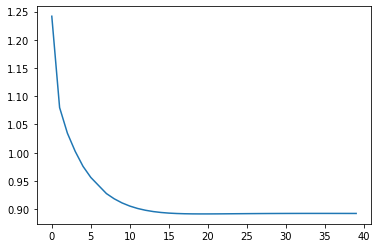

Epoch 1/50
1/1 - 2s - loss: 1.0658 - accuracy: 0.5116 - auc_39: 0.6283 - precision_39: 0.8000 - recall_39: 0.0310 - f1_score: 0.2791 - val_loss: 0.9782 - val_accuracy: 0.5156 - val_auc_39: 0.7225 - val_precision_39: 0.5156 - val_recall_39: 0.5156 - val_f1_score: 0.2268 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 0.9191 - accuracy: 0.6202 - auc_39: 0.7653 - precision_39: 0.6202 - recall_39: 0.6202 - f1_score: 0.2552 - val_loss: 0.9610 - val_accuracy: 0.5156 - val_auc_39: 0.7230 - val_precision_39: 0.5156 - val_recall_39: 0.5156 - val_f1_score: 0.2268 - 97ms/epoch - 97ms/step
Epoch 3/50
1/1 - 0s - loss: 0.9051 - accuracy: 0.6202 - auc_39: 0.7676 - precision_39: 0.6160 - recall_39: 0.5969 - f1_score: 0.2552 - val_loss: 0.9470 - val_accuracy: 0.5156 - val_auc_39: 0.7333 - val_precision_39: 0.5156 - val_recall_39: 0.5156 - val_f1_score: 0.2268 - 97ms/epoch - 97ms/step
Epoch 4/50
1/1 - 0s - loss: 0.8901 - accuracy: 0.6202 - auc_39: 0.7754 - precision_39: 0.6202 - recall_39: 0.6202 - f1_

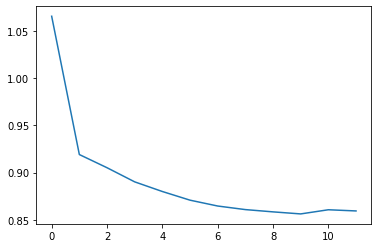

In [48]:
model2 = get_CNN(n_features, n_length, n_outputs, y_train.shape[1])
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model2 = get_CNN(n_features, n_length, n_outputs, y_train.shape[1])
    history = train(model2, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [49]:
member2 = KerasMember(name="CNN+LSTM", keras_model=model2,
    train_batches=(X_train, y_train),
    val_batches=(X_test, y_test))

### Train ConvLSTM (with early fusion)

Epoch 1/50
1/1 - 3s - loss: 74.0826 - accuracy: 0.3750 - auc_41: 0.5312 - precision_41: 0.3750 - recall_41: 0.3750 - f1_score: 0.1969 - val_loss: 937.4266 - val_accuracy: 0.6000 - val_auc_41: 0.7000 - val_precision_41: 0.6000 - val_recall_41: 0.6000 - val_f1_score: 0.2500 - 3s/epoch - 3s/step
Epoch 2/50
1/1 - 0s - loss: 1031.0159 - accuracy: 0.5781 - auc_41: 0.6836 - precision_41: 0.5781 - recall_41: 0.5781 - f1_score: 0.2442 - val_loss: 448.2613 - val_accuracy: 0.6000 - val_auc_41: 0.7000 - val_precision_41: 0.6000 - val_recall_41: 0.6000 - val_f1_score: 0.2500 - 342ms/epoch - 342ms/step
Epoch 3/50
1/1 - 0s - loss: 503.9681 - accuracy: 0.5781 - auc_41: 0.6836 - precision_41: 0.5781 - recall_41: 0.5781 - f1_score: 0.2442 - val_loss: 585.7548 - val_accuracy: 0.0923 - val_auc_41: 0.3192 - val_precision_41: 0.0923 - val_recall_41: 0.0923 - val_f1_score: 0.0563 - 331ms/epoch - 331ms/step
Epoch 4/50
1/1 - 0s - loss: 606.1620 - accuracy: 0.0625 - auc_41: 0.2969 - precision_41: 0.0625 - recal

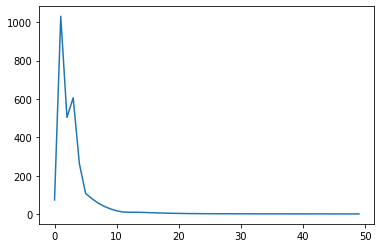

Epoch 1/50
1/1 - 3s - loss: 9.0078 - accuracy: 0.5736 - auc_42: 0.6754 - precision_42: 0.5736 - recall_42: 0.5736 - f1_score: 0.2896 - val_loss: 614.9665 - val_accuracy: 0.2969 - val_auc_42: 0.4727 - val_precision_42: 0.2969 - val_recall_42: 0.2969 - val_f1_score: 0.1526 - 3s/epoch - 3s/step
Epoch 2/50
1/1 - 0s - loss: 549.3289 - accuracy: 0.3643 - auc_42: 0.5233 - precision_42: 0.3643 - recall_42: 0.3643 - f1_score: 0.1780 - val_loss: 262.0497 - val_accuracy: 0.2969 - val_auc_42: 0.4727 - val_precision_42: 0.2969 - val_recall_42: 0.2969 - val_f1_score: 0.1526 - 338ms/epoch - 338ms/step
Epoch 3/50
1/1 - 0s - loss: 237.3842 - accuracy: 0.3643 - auc_42: 0.5233 - precision_42: 0.3643 - recall_42: 0.3643 - f1_score: 0.1780 - val_loss: 233.2521 - val_accuracy: 0.0625 - val_auc_42: 0.2969 - val_precision_42: 0.0625 - val_recall_42: 0.0625 - val_f1_score: 0.0392 - 318ms/epoch - 318ms/step
Epoch 4/50
1/1 - 0s - loss: 237.9118 - accuracy: 0.0775 - auc_42: 0.3081 - precision_42: 0.0775 - recall_

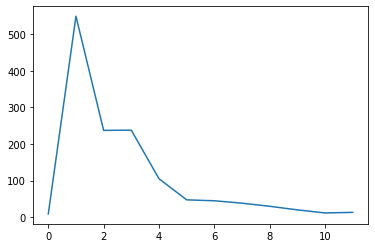

Epoch 1/50
1/1 - 3s - loss: 42.6914 - accuracy: 0.2481 - auc_43: 0.4225 - precision_43: 0.2481 - recall_43: 0.2481 - f1_score: 0.1990 - val_loss: 792.0065 - val_accuracy: 0.5156 - val_auc_43: 0.6367 - val_precision_43: 0.5156 - val_recall_43: 0.5156 - val_f1_score: 0.2268 - 3s/epoch - 3s/step
Epoch 2/50
1/1 - 0s - loss: 632.3184 - accuracy: 0.6202 - auc_43: 0.7151 - precision_43: 0.6202 - recall_43: 0.6202 - f1_score: 0.2552 - val_loss: 447.4039 - val_accuracy: 0.5156 - val_auc_43: 0.6367 - val_precision_43: 0.5156 - val_recall_43: 0.5156 - val_f1_score: 0.2268 - 337ms/epoch - 337ms/step
Epoch 3/50
1/1 - 0s - loss: 360.8496 - accuracy: 0.6202 - auc_43: 0.7151 - precision_43: 0.6202 - recall_43: 0.6202 - f1_score: 0.2552 - val_loss: 166.9570 - val_accuracy: 0.5156 - val_auc_43: 0.6367 - val_precision_43: 0.5156 - val_recall_43: 0.5156 - val_f1_score: 0.2268 - 308ms/epoch - 308ms/step
Epoch 4/50
1/1 - 0s - loss: 149.7251 - accuracy: 0.6202 - auc_43: 0.7151 - precision_43: 0.6202 - recall

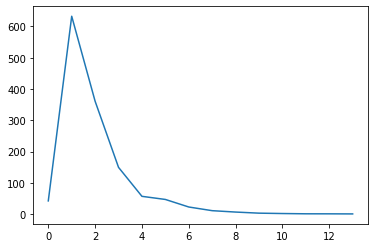

In [50]:
model3 = build_convLSTM(n_features, n_length, n_outputs, y_train.shape[1])
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model3 = build_convLSTM(n_features, n_length, n_outputs, y_train.shape[1])
    history = train(model3, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [51]:
member3 = KerasMember(name="ConvLSTM", keras_model=model3,
    train_batches=(X_train, y_train),
    val_batches=(X_test, y_test))

### Train RCNN (with early fusion)

Epoch 1/50
1/1 - 2s - loss: 1.4723 - accuracy: 0.3750 - auc_45: 0.5375 - precision_45: 0.3293 - recall_45: 0.2109 - f1_score: 0.2981 - val_loss: 2158.5779 - val_accuracy: 0.6000 - val_auc_45: 0.7000 - val_precision_45: 0.6000 - val_recall_45: 0.6000 - val_f1_score: 0.2500 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 29.7325 - accuracy: 0.5781 - auc_45: 0.6870 - precision_45: 0.5781 - recall_45: 0.5781 - f1_score: 0.2442 - val_loss: 1168.8829 - val_accuracy: 0.6000 - val_auc_45: 0.7000 - val_precision_45: 0.6000 - val_recall_45: 0.6000 - val_f1_score: 0.2500 - 334ms/epoch - 334ms/step
Epoch 3/50
1/1 - 0s - loss: 17.1208 - accuracy: 0.5781 - auc_45: 0.7013 - precision_45: 0.5781 - recall_45: 0.5781 - f1_score: 0.2442 - val_loss: 469.7871 - val_accuracy: 0.6000 - val_auc_45: 0.7000 - val_precision_45: 0.6000 - val_recall_45: 0.6000 - val_f1_score: 0.2500 - 388ms/epoch - 388ms/step
Epoch 4/50
1/1 - 0s - loss: 5.6057 - accuracy: 0.6328 - auc_45: 0.7516 - precision_45: 0.6378 - recall_45

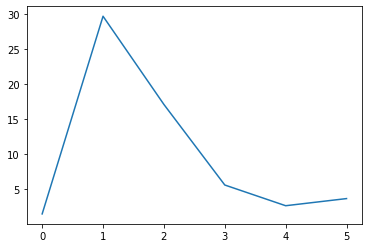

Epoch 1/50
1/1 - 2s - loss: 1.7483 - accuracy: 0.3256 - auc_46: 0.4646 - precision_46: 0.3068 - recall_46: 0.2093 - f1_score: 0.2787 - val_loss: 1541.2913 - val_accuracy: 0.6406 - val_auc_46: 0.7305 - val_precision_46: 0.6406 - val_recall_46: 0.6406 - val_f1_score: 0.2603 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 29.4136 - accuracy: 0.5581 - auc_46: 0.6727 - precision_46: 0.5581 - recall_46: 0.5581 - f1_score: 0.2388 - val_loss: 840.7544 - val_accuracy: 0.6406 - val_auc_46: 0.7305 - val_precision_46: 0.6406 - val_recall_46: 0.6406 - val_f1_score: 0.2603 - 321ms/epoch - 321ms/step
Epoch 3/50
1/1 - 0s - loss: 19.1110 - accuracy: 0.5659 - auc_46: 0.6868 - precision_46: 0.5659 - recall_46: 0.5659 - f1_score: 0.2539 - val_loss: 315.5726 - val_accuracy: 0.6406 - val_auc_46: 0.7305 - val_precision_46: 0.6406 - val_recall_46: 0.6406 - val_f1_score: 0.2603 - 344ms/epoch - 344ms/step
Epoch 4/50
1/1 - 0s - loss: 7.7121 - accuracy: 0.6434 - auc_46: 0.7735 - precision_46: 0.6434 - recall_46:

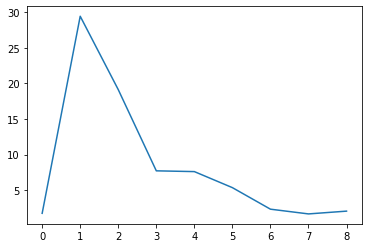

Epoch 1/50
1/1 - 2s - loss: 1.8754 - accuracy: 0.2403 - auc_47: 0.4194 - precision_47: 0.2234 - recall_47: 0.1628 - f1_score: 0.1964 - val_loss: 641.6666 - val_accuracy: 0.5156 - val_auc_47: 0.6367 - val_precision_47: 0.5156 - val_recall_47: 0.5156 - val_f1_score: 0.2268 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 9.5089 - accuracy: 0.6202 - auc_47: 0.7437 - precision_47: 0.6202 - recall_47: 0.6202 - f1_score: 0.2552 - val_loss: 824.2751 - val_accuracy: 0.4219 - val_auc_47: 0.5664 - val_precision_47: 0.4219 - val_recall_47: 0.4219 - val_f1_score: 0.1978 - 373ms/epoch - 373ms/step
Epoch 3/50
1/1 - 0s - loss: 18.0505 - accuracy: 0.3178 - auc_47: 0.5213 - precision_47: 0.3178 - recall_47: 0.3178 - f1_score: 0.1783 - val_loss: 251.7606 - val_accuracy: 0.4844 - val_auc_47: 0.6133 - val_precision_47: 0.4844 - val_recall_47: 0.4844 - val_f1_score: 0.3061 - 328ms/epoch - 328ms/step
Epoch 4/50
1/1 - 0s - loss: 5.8255 - accuracy: 0.6279 - auc_47: 0.7776 - precision_47: 0.6279 - recall_47: 0

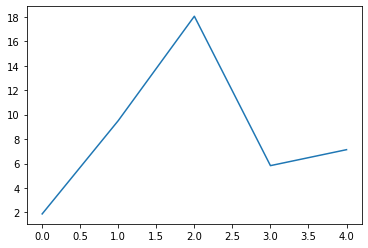

In [52]:
model4 = build_RCNN(n_features, n_length, n_outputs, y_train.shape[1])
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model4 = build_RCNN(n_features, n_length, n_outputs, y_train.shape[1])
    history = train(model4, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [53]:
member4 = KerasMember(name="RCNN", keras_model=model4,
    train_batches=(X_train, y_train),
    val_batches=(X_test, y_test))

### Stacking Ensemble

In [54]:
early_stackEnsemble = StackEnsemble()
early_stackEnsemble.add_member(member1)
early_stackEnsemble.add_member(member2)
early_stackEnsemble.add_member(member3)
early_stackEnsemble.add_member(member4)

In [55]:
early_stackEnsemble.fit()

RandomForestClassifier(max_depth=4, n_jobs=20)

### Dirichlet Markov Ensemble

In [56]:
early_dirichletEnsemble = DirichletEnsemble()
early_dirichletEnsemble.add_member(member1)
early_dirichletEnsemble.add_member(member2)
early_dirichletEnsemble.add_member(member3)
early_dirichletEnsemble.add_member(member4)

In [57]:
early_dirichletEnsemble.fit()

## 3. Late Fusion - Fusion is performed at decision level

In late fusion, uni-modal classifiers are trained individually and their predictions are aggregated somehow. 
I consider two types of late fusion approaches:

1. Using meta-learner ensembles; and 

Each ensemble member provides predictions to train a meta-learner (ensemble) and that ensemble is in charge of producing the final classification. I have tested a Stacking Ensemble with Majority voting, and a Dirichlet Markov Ensemble with weighted soft voting.

A drawback with the ensemble approach is that I only work with two modalities => no ensemble if one modality is missing. It would have been more interesting with 3+ modalities. Additionally, I can't use models that require different input shapes which is slightly limiting.

Another drawback could be that I'm unsure how diverse my ensemble members are, and a lack of diversity could result in them making the same errors and wrong guesses => no real improvement in performance.

2. Model-free approaches where fusion is performed at decision level. 

## Performance Evaluation on Test set

### Uni-Modal Approaches (only Body/Skeleton data)

In [58]:
s = skeleton_stackEnsemble.describe()

BiLSTM - ROC/AUC: 0.50, Accuracy: 25.56%, Precision: 0.14, Recall: 0.27, F1 score: 0.17 

CNN+LSTM - ROC/AUC: 0.49, Accuracy: 32.22%, Precision: 0.08, Recall: 0.25, F1 score: 0.12 

ConvLSTM - ROC/AUC: 0.50, Accuracy: 14.44%, Precision: 0.04, Recall: 0.25, F1 score: 0.06 

RCNN - ROC/AUC: 0.47, Accuracy: 14.44%, Precision: 0.04, Recall: 0.25, F1 score: 0.06 

StackEnsemble - ROC/AUC: 0.50, Accuracy: 30.00%, Precision: 0.11, Recall: 0.24, F1 score: 0.14


In [59]:
s = skeleton_dirichletEnsemble.describe()

BiLSTM (weight: 0.4386)
CNN+LSTM (weight: 0.1027)
ConvLSTM (weight: 0.3690)
RCNN (weight: 0.0897)
DirichletEnsemble - ROC/AUC: 0.51, Accuracy: 32.22%, Precision: 0.16, Recall: 0.27, F1 score: 0.17


### Uni-Modal Approaches (only Facial Expression/Action Units)

In [60]:
s = facial_stackEnsemble.describe()

BiLSTM - ROC/AUC: 0.46, Accuracy: 59.52%, Precision: 0.20, Recall: 0.33, F1 score: 0.25 

CNN+LSTM - ROC/AUC: 0.50, Accuracy: 59.52%, Precision: 0.20, Recall: 0.33, F1 score: 0.25 

ConvLSTM - ROC/AUC: 0.39, Accuracy: 59.52%, Precision: 0.20, Recall: 0.33, F1 score: 0.25 

RCNN - ROC/AUC: 0.47, Accuracy: 59.52%, Precision: 0.20, Recall: 0.33, F1 score: 0.25 

StackEnsemble - ROC/AUC: 0.40, Accuracy: 40.48%, Precision: 0.20, Recall: 0.24, F1 score: 0.22


In [61]:
s = facial_dirichletEnsemble.describe()

BiLSTM (weight: 0.0704)
CNN+LSTM (weight: 0.9139)
ConvLSTM (weight: 0.0128)
RCNN (weight: 0.0029)
DirichletEnsemble - ROC/AUC: 0.50, Accuracy: 59.52%, Precision: 0.20, Recall: 0.33, F1 score: 0.25


### Early Fusion Approaches (features combined at input level)

In [62]:
s = early_stackEnsemble.describe()

BiLSTM - ROC/AUC: 0.45, Accuracy: 59.52%, Precision: 0.20, Recall: 0.33, F1 score: 0.25 

CNN+LSTM - ROC/AUC: 0.60, Accuracy: 59.52%, Precision: 0.20, Recall: 0.33, F1 score: 0.25 

ConvLSTM - ROC/AUC: 0.51, Accuracy: 57.14%, Precision: 0.20, Recall: 0.32, F1 score: 0.24 

RCNN - ROC/AUC: 0.50, Accuracy: 59.52%, Precision: 0.20, Recall: 0.33, F1 score: 0.25 

StackEnsemble - ROC/AUC: 0.49, Accuracy: 59.52%, Precision: 0.20, Recall: 0.33, F1 score: 0.25


In [63]:
s = early_dirichletEnsemble.describe()

BiLSTM (weight: 0.0640)
CNN+LSTM (weight: 0.0116)
ConvLSTM (weight: 0.8888)
RCNN (weight: 0.0355)
DirichletEnsemble - ROC/AUC: 0.60, Accuracy: 59.52%, Precision: 0.20, Recall: 0.33, F1 score: 0.25
